In [1]:
import torch
import random

def load_pyg_dataset(file_path):
    return torch.load(file_path)

output_file_path = 'output/pyg_dataset_for_god_component.pt'
dataset = load_pyg_dataset(output_file_path)

def add_train_mask_to_pyg_data(data, train_ratio=0.8):
    num_nodes = data.num_nodes
    num_train_nodes = int(train_ratio * num_nodes)

    # Generate a list of True and False values with the specified ratio
    mask_values = [True] * num_train_nodes + [False] * (num_nodes - num_train_nodes)

    # Randomly shuffle the mask values
    random.shuffle(mask_values)

    # Convert the mask_values list to a boolean tensor and assign it to the Data object
    data.train_mask = torch.tensor(mask_values, dtype=torch.bool)

def add_test_mask_to_pyg_data(data):
    # If the train_mask is not set, raise an exception
    if not hasattr(data, 'train_mask'):
        raise ValueError("Please add a train_mask to the Data object first.")
    
    # Create a test mask as the complement of the train mask
    data.test_mask = ~data.train_mask


add_train_mask_to_pyg_data(dataset, train_ratio=0.8)
add_test_mask_to_pyg_data(dataset)

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Data(x=[42, 10], edge_index=[2, 852], y=[42], num_classes=2, train_mask=[42], test_mask=[42]):
Number of graphs: 6
Number of features: 10
Number of classes: 2

Data(x=[42, 10], edge_index=[2, 852], y=[42], num_classes=2, train_mask=[42], test_mask=[42])
Number of nodes: 42
Number of edges: 852
Average node degree: 20.29
Number of training nodes: 33
Training node label rate: 0.79
Has isolated nodes: False
Has self-loops: False
Is undirected: False


In [2]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=10, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=2, bias=True)
)


In [3]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 1001):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 100.3816
Epoch: 002, Loss: 80.8453
Epoch: 003, Loss: 112.4376
Epoch: 004, Loss: 79.5428
Epoch: 005, Loss: 54.2704
Epoch: 006, Loss: 26.4686
Epoch: 007, Loss: 81.4409
Epoch: 008, Loss: 53.6784
Epoch: 009, Loss: 33.4253
Epoch: 010, Loss: 24.9676
Epoch: 011, Loss: 28.5472
Epoch: 012, Loss: 23.9781
Epoch: 013, Loss: 4.7078
Epoch: 014, Loss: 12.8042
Epoch: 015, Loss: 10.5096
Epoch: 016, Loss: 4.9443
Epoch: 017, Loss: 8.6123
Epoch: 018, Loss: 6.8175
Epoch: 019, Loss: 6.4364
Epoch: 020, Loss: 6.4503
Epoch: 021, Loss: 8.3128
Epoch: 022, Loss: 6.3669
Epoch: 023, Loss: 3.6862
Epoch: 024, Loss: 2.4334
Epoch: 025, Loss: 4.3856
Epoch: 026, Loss: 5.8909
Epoch: 027, Loss: 1.5258
Epoch: 028, Loss: 3.5807
Epoch: 029, Loss: 2.7948
Epoch: 030, Loss: 3.2840
Epoch: 031, Loss: 2.8078
Epoch: 032, Loss: 5.4792
Epoch: 033, Loss: 1.4583
Epoch: 034, Loss: 0.8815
Epoch: 035, Loss: 2.4683
Epoch: 036, Loss: 1.0124
Epoch: 037, Loss: 0.5569
Epoch: 038, Loss: 1.9946
Epoch: 039, Loss: 2.0792
Epoch: 04

In [4]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7778


In [5]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(10, 16)
  (conv2): GCNConv(16, 2)
)


In [6]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)

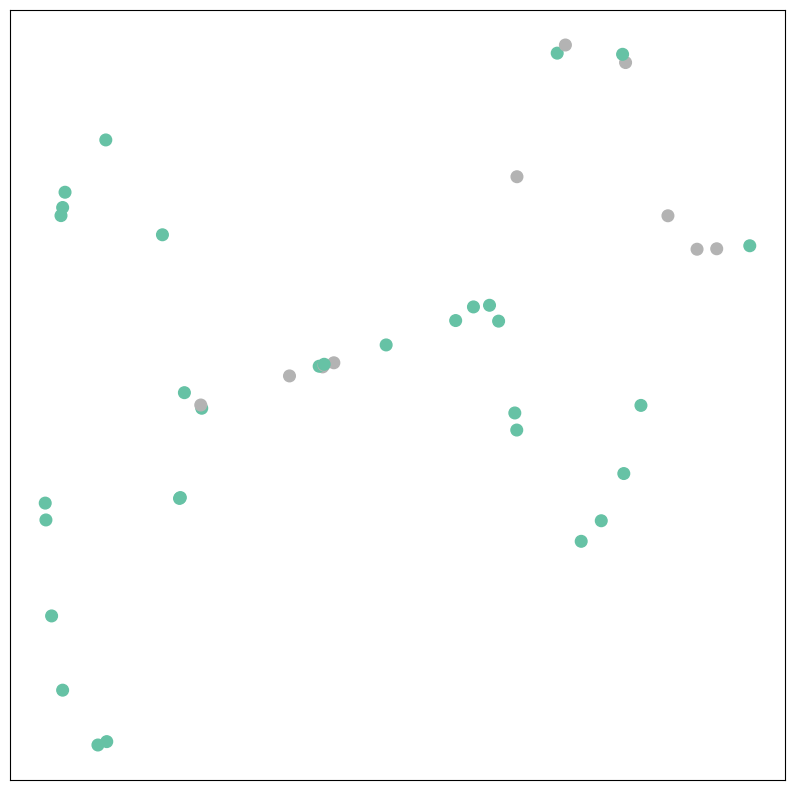

In [8]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()
    
visualize(out, color=data.y)

In [9]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 1001):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 185.2738
Epoch: 002, Loss: 273.2421
Epoch: 003, Loss: 325.3930
Epoch: 004, Loss: 469.2708
Epoch: 005, Loss: 360.8531
Epoch: 006, Loss: 192.2220
Epoch: 007, Loss: 263.9642
Epoch: 008, Loss: 175.7042
Epoch: 009, Loss: 212.4756
Epoch: 010, Loss: 131.5805
Epoch: 011, Loss: 179.8949
Epoch: 012, Loss: 165.4581
Epoch: 013, Loss: 180.1632
Epoch: 014, Loss: 281.6281
Epoch: 015, Loss: 262.3132
Epoch: 016, Loss: 302.4248
Epoch: 017, Loss: 253.4167
Epoch: 018, Loss: 212.7361
Epoch: 019, Loss: 194.8268
Epoch: 020, Loss: 361.5850
Epoch: 021, Loss: 275.7124
Epoch: 022, Loss: 211.8102
Epoch: 023, Loss: 138.6277
Epoch: 024, Loss: 224.7197
Epoch: 025, Loss: 123.8644
Epoch: 026, Loss: 170.0559
Epoch: 027, Loss: 305.3237
Epoch: 028, Loss: 261.0532
Epoch: 029, Loss: 265.5054
Epoch: 030, Loss: 153.2802
Epoch: 031, Loss: 287.5713
Epoch: 032, Loss: 223.0547
Epoch: 033, Loss: 200.5465
Epoch: 034, Loss: 128.3061
Epoch: 035, Loss: 76.0163
Epoch: 036, Loss: 93.3613
Epoch: 037, Loss: 51.0141
Epoc

In [10]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.6667


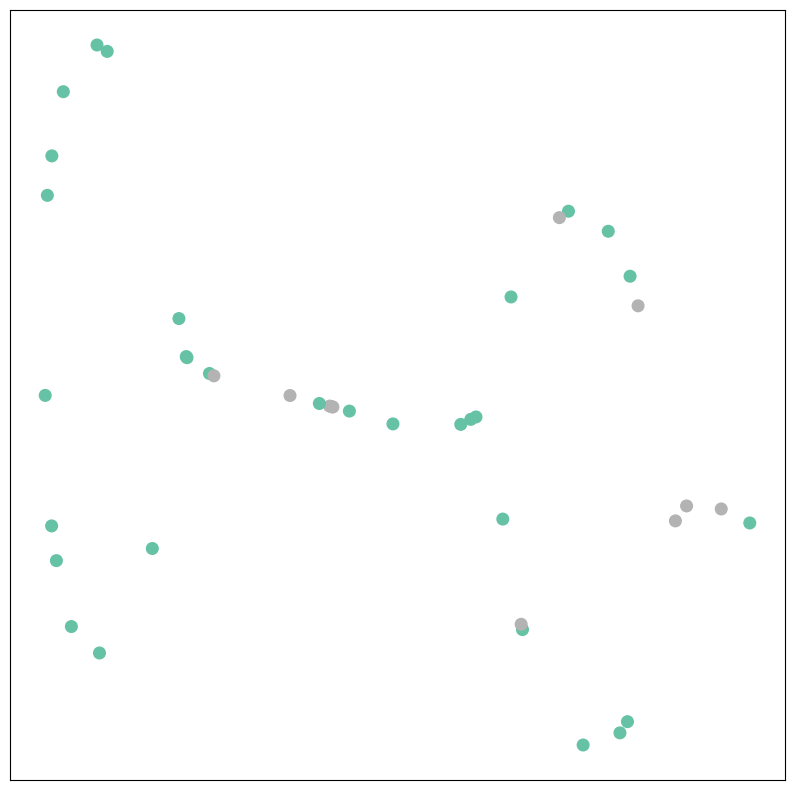

In [11]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)